In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from segment_anything import sam_model_registry, SamPredictor

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

## extract segmented part from original image
def extract_segmented(orig_image, seg_image):
    # set the dimension of segmented image to original image
    new_shape = (orig_image.shape[0], orig_image.shape[1], orig_image.shape[2])
    result = np.empty(new_shape, dtype=np.uint8)
    result[..., :seg_image.shape[-1]] = seg_image[..., np.newaxis]

    # extract segmented and save
    result = orig_image * result
    target_color = [0, 0, 0]
    mask = np.all(result == target_color, axis=-1)
    result[mask] = [255, 255, 255]
    # cv2.imwrite('2.jpg', result)
    return result

# calculate percentage of skin color
def calculate_color_perc(image):
    orig_image = image.copy()

    # Convert to HSV
    hsv_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2HSV)

    # set color range
    lower_skin = np.array([0, 50, 95], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # calculate percentage of skin color
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
    total_pixels = orig_image.shape[0] * orig_image.shape[1]
    percentage_skin = (np.count_nonzero(skin_mask) / total_pixels) * 100

    # show
    print(f"Percentage of skin color: {percentage_skin:.2f}%")
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[1].imshow(skin_mask)
    plt.show()

# segmentation
def segment_hair(image, option=False):
    predictor.set_image(image)
    
    # set the point
    input_point = np.array([[256, 256]])
    input_label = np.array([0])

    if option:
        # show
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        show_points(input_point, input_label, plt.gca())
        plt.axis('on')
        plt.show()

    # predict
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    # get the highest score mask
    highest_score = np.argmax(scores)
    mask = masks[highest_score]
    return mask

In [5]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
image = cv2.imread('1.jpg')
image = cv2.resize(image, dsize=(512, 512), interpolation=cv2.INTER_AREA)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

mask = segment_hair(image)
# segmented = extract_segmented(image, mask)
# calculate_color_perc(segmented)

Percentage of skin color: 12.92%


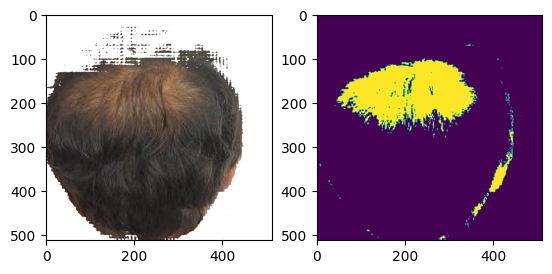

Percentage of skin color: 8.86%


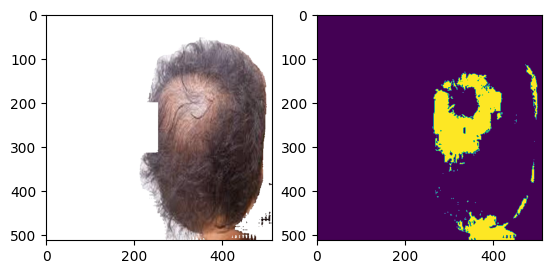

KeyboardInterrupt: 

In [7]:
# 전체 데이터의 평균
import os

for subpth in ['train', 'test', 'val']:
    pth = os.path.join('data', subpth, '1')
    for file in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, file))
        img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
        mask = segment_hair(img)
        segmented = extract_segmented(img, mask)
        calculate_color_perc(segmented)

